In [1]:
cd /content/drive/My Drive/Colab Notebooks/tobigs

/content/drive/My Drive/Colab Notebooks/tobigs


In [2]:
ls

 kaggle.json             test_df.csv                    train_df.csv
 sample_submission.csv   test_df.csv.zip                train_df.csv.zip
 submission.csv         'Tobigs_Kannada digits.ipynb'


In [0]:
import pandas as pd
import numpy as np

In [0]:
sample_submission = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test_df.csv")
train = pd.read_csv("train_df.csv")

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
print("train data shape {}".format(train.shape))
print("test data shape {}".format(test.shape))

train data shape (42000, 785)
test data shape (18000, 785)


#### 785 = 0~784 까지 있는건데 (라벨:1개, 28*28=784)

# Preprocessing

In [0]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [0]:
import tensorflow as tf

In [10]:
X = X / 255  # 각 픽셀 값이 0과 1 사이의 값을 갖도록 픽셀 값을 정규화하는 것이 좋습니다.
X 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

For most image data, the pixel values are integers with values between 0 and 255. 


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2020)

## Visualization


5


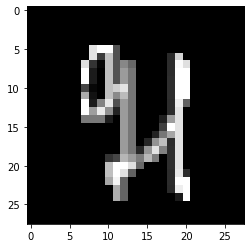

In [12]:
import matplotlib.pyplot as plt
idx = 10
print(y_train[idx])
plt.imshow(x_train[idx].reshape(28, 28), cmap="gray")

In [0]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)


In [14]:
x_train.shape

(33600, 28, 28, 1)

1. activation function : CNN 에서는 relu 의 성능이 좋다고 했으니까 relu를 사용하자. + 딥러닝에서 가장 많이 사용하는 활성화 함수다. 

2. weight initialization : Glorot uniform initializer, also called **Xavier** uniform initializer. (default 가 이거인듯) + he_normal 도 시도해 봤지만 Xavier가 더 성능이 좋게 나왔음.

3. batchnormalization 

4. max pooling : 추출된 activation function 을 임의로 줄이는 작업. 

5. optimization : RMSprop(multiclass 구분 에서 자주 쓰인다고 한다) 와 Adam 을 각각 사용해보았다.

6. regularization
  - drop out
  -  early stoppping : patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의한다. verbose=1 로 지정하면, 언제 keras 에서 training 을 멈추었는지를 화면에 출력할 수 있다. 




In [15]:
num_classes = 10
rate = 0.3

model = tf.keras.models.Sequential([  # 순차적으로 모델을 만드는 방법 

        # 필터를 kernel 이라고 한다.
        # padding : 입력데이터 외각에 지정된 픽셀만큼 특정값으로 채우는것 = 보통 0                         
        tf.keras.layers.Conv2D( 64, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), padding="same"),  
        tf.keras.layers.BatchNormalization(momentum=0.9), 
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(rate), 

        tf.keras.layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding="same"),  
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Conv2D(128,kernel_size=(3,3), activation='relu',padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128,kernel_size=(3,3), activation='relu',padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(rate), 

        tf.keras.layers.Conv2D(256,kernel_size=(3,3), activation='relu',padding="same"),  
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(rate),

        tf.keras.layers.Flatten(),   # 쭉 펴주는 부분 
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation="softmax"),                      
])


#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0

In [16]:
history = model.fit(x_train, y_train, batch_size=512, epochs=40, validation_data=[x_val, y_val])

Train on 33600 samples, validate on 8400 samples
Epoch 1/40
33600/33600 [==============================] - 21s 640us/sample - loss: 0.1793 - accuracy: 0.9477 - val_loss: 0.6670 - val_accuracy: 0.8255
Epoch 2/40
33600/33600 [==============================] - 14s 423us/sample - loss: 0.0427 - accuracy: 0.9883 - val_loss: 0.1209 - val_accuracy: 0.9701
Epoch 3/40
33600/33600 [==============================] - 14s 426us/sample - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.0775 - val_accuracy: 0.9811
Epoch 4/40
33600/33600 [==============================] - 14s 425us/sample - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0385 - val_accuracy: 0.9919
Epoch 5/40
33600/33600 [==============================] - 14s 424us/sample - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.0696 - val_accuracy: 0.9845
Epoch 6/40
33600/33600 [==============================] - 14s 426us/sample - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0825 - val_accuracy: 0.9799
Epoch 7/40
33600/33600 [=====================

In [17]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(33600, 28, 28, 1) (33600,) (8400, 28, 28, 1) (8400,)


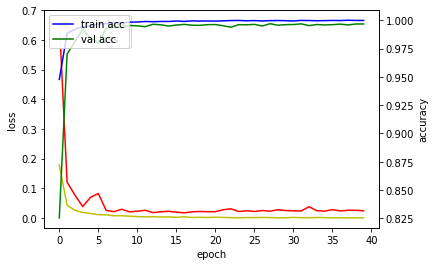

In [18]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [0]:
x_test = test.iloc[:,1:].values / 255

In [0]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [0]:
prediction = model.predict_classes(x_test)

In [22]:
prediction

array([8, 0, 5, ..., 3, 4, 1])

In [23]:
sample_submission.head()

,Id,Category
0,57808,0
1,4960,0
2,35755,0
3,15543,0
4,48968,0


In [24]:
sample_submission["Category"] = pd.Series(prediction)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [27]:
submission = sample_submission[["Id", "Category"]]
submission

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8
...,...,...
17995,53718,8
17996,78,8
17997,33373,3
17998,36134,4


In [0]:
submission.to_csv("submission.csv", index=False)